Test of the IRAF OFILT algorithm ported to python
--------

The algorithm is briefly described in the [fitskypars help manual](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?fitskypars), but is basically a triangle weighting to the peak of the sky histogram, after an initial mean estimate and some optional clipping. The algorithm works well in the case of quantized data ([ISR WFPC2 96-03](http://www.stsci.edu/hst/wfpc2/documents/isr/wfpc2_isr9603.pdf) ).

The test here uses some fake data drawn from a pure Gaussian with and without quantization to test how well it finds the peak.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import ofiltsky

%matplotlib inline

Create a 1D array of flux values drawn from a Gaussian distribution with a fairly small sigma. Add a small constant offset to each flux (equivalent, for example to a bias level for a CCD). Then quantize and return both the floating point and the quantized versions of this array.

In [18]:
def realization(mean,sigma,offset,nsamp=1000000):
    floatmean =  stats.norm(loc=mean+offset,scale=sigma).rvs(nsamp)
    intmean = (floatmean+0.5).astype(np.int32)
    return floatmean,intmean

In [19]:
f,i = realization(100.,0.1,0.)

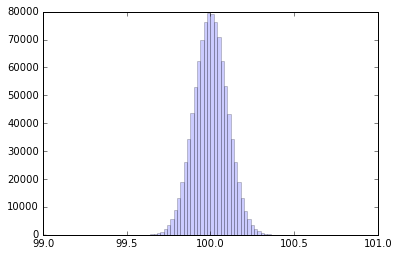

In [20]:
foo = plt.hist(f,np.arange(99.,101.,0.02),alpha=0.2)

For convenience, run ofilter and just return its estimate of the central value.

In [21]:
def ofil(data,binsize=0.1):
    return ofiltsky.fitsky_ofilter(data,sigclip_sigma=None,binsize=binsize)[0]

Now compare the estimates from three different techniques, operating on each of the floating point and the integer versions of the array: 
 * An unclipped mean
 * An unclipped median
 * ofilter

In [23]:
f0,i0 = realization(100.,1.,0.)
f1,i1 = realization(100.,1.,0.1)
f2,i2 = realization(100.,1.,0.2)
print "Mean of floating point versions: ", f0.mean(),f1.mean(),f2.mean()
print "Mean of integer versions: ",i0.mean(),i1.mean(),i2.mean()
print "Median of float versions: ",np.median(f0),np.median(f1),np.median(f2)
print "Median of integer versions: ",np.median(i0),np.median(i1),np.median(i2)
print "Ofilt of floating point versions", ofil(f0),ofil(f1),ofil(f2)
print "Ofilt of integer point versions", ofil(i0),ofil(i1),ofil(i2)

Mean of floating point versions:  100.001963262 100.09962256 100.199014551
Mean of integer versions:  100.002011 100.099574 100.199954
Median of float versions:  100.001981462 100.100267182 100.197531323
Median of integer versions:  100.0 100.0 100.0
Ofilt of floating point versions 100.002084585 100.100140158 100.198251551
Ofilt of integer point versions 100.054568918 100.152053611 100.25208321


Results
----

All three estimates look comparable on the floating point data. 
The standard-error of the mean for one million samples if the standard deviation 
is 1.0 should be 1/sqrt(1e6) = 0.001. 
The estimate from the mean is within that for all three values of the offset, 
for both the floating point and integer versions.

The estimate from the median is okay for the floating point version, but (as expected) 
offset for the versions where there was a non-integer constant offset.

The estimate from ofilter is systematically high for the floating point version. 
It is certainly closer than the median for the integer version, but is still systematically high.

Is there a trend with the offset?
--------

Repeat the same test, varying the offset and plot the trend.

In [24]:
def repeat(realization,sigma=1.,nsamp=100000,val=100,binsize=0.1,plotmed=True):
    offset = np.arange(-1.,1.,0.02)
    fmean = offset*0.
    imean = offset*0.
    fmedian = offset*0.
    imedian = offset*0.
    fofilt = offset*0.
    iofilt = offset*0.
    for n,o in enumerate(offset):
        f,i = realization(val,sigma,o,nsamp=nsamp)
        fmean[n],fmedian[n],fofilt[n] = f.mean(),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = i.mean(),np.median(i),ofil(i,binsize=binsize)
    plt.plot(offset,fmean-offset,'o',label='mean',alpha=0.3)
    if plotmed:
        plt.plot(offset,imedian-offset,'o',label='int median',alpha=0.3)
        plt.plot(offset,fmedian-offset,'s',label='float median',alpha=0.3)
    plt.plot(offset,fofilt-offset,'d',label='float ofilt',alpha=0.3)
    plt.plot(offset,iofilt-offset,'d',label='int ofilt',alpha=0.3)
    plt.legend()
#   return offset, fmean, imean, fmedian, imedian, fofilt, iofilt

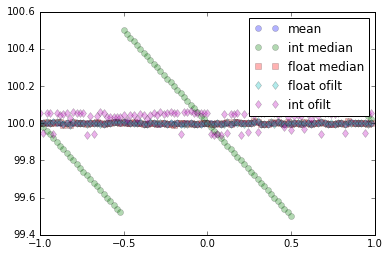

In [8]:
results = repeat(realization)

The trend is not entirely systematic, but the offset seems to be about 0.05
in one direction or the other, so probably has to do with the bin size used
by the ofilt algorithm. 

Is it unacceptably far off?
--------
Compare the offset to the expected standard-error-of-the-mean $\sigma/\sqrt(N)$.


In [25]:
def repeat_relative(realization,sigma=5.,nsamp=100000,val=100,binsize=0.1,plotmed=True):
    offset = np.arange(-1.,1.,0.02)
    fmean = offset*0.
    imean = offset*0.
    fmedian = offset*0.
    imedian = offset*0.
    fofilt = offset*0.
    iofilt = offset*0.
    stderr = sigma/np.sqrt(nsamp)
    for n,o in enumerate(offset):
        f,i = realization(val,sigma,o,nsamp=nsamp)
        fmean[n],fmedian[n],fofilt[n] = f.mean(),np.median(f),ofil(f,binsize=binsize)
        imean[n],imedian[n],iofilt[n] = i.mean(),np.median(i),ofil(i,binsize=binsize)
    plt.plot(offset,(fmean-val-offset)/stderr,'o',label='mean',alpha=0.3)
    if plotmed:
        plt.plot(offset,(imedian-val-offset)/stderr,'o',label='int median',alpha=0.3)
        plt.plot(offset,(fmedian-val-offset)/stderr,'s',label='float median',alpha=0.3)
    plt.plot(offset,(fofilt-val-offset)/stderr,'d',label='float ofilt',alpha=0.3)
    plt.plot(offset,(iofilt-val-offset)/stderr,'d',label='int ofilt',alpha=0.3)
    plt.ylim(-50,50)
    plt.legend()

Try first with the default binsize of 0.1 (hypothesizing that the offset is due to this 
pixilization of the histogram and how you define the center). 

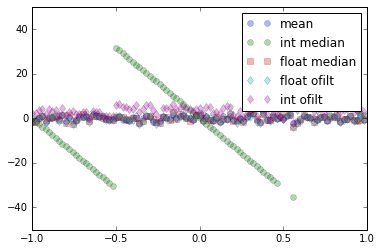

In [26]:
repeat_relative(realization)

Yes. It is unacceptably low (by nearly a factor of 20). 
Now try with a smaller binsize

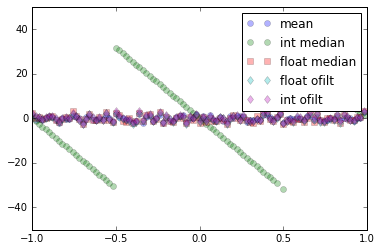

In [27]:
repeat_relative(realization,binsize=0.01)

In [28]:
f0,i0 = realization(100.,1.,0.)
f1,i1 = realization(100.,1.,0.1)
f2,i2 = realization(100.,1.,0.2)
print "Mean of floating point versions: ", f0.mean(),f1.mean(),f2.mean()
print "Mean of integer versions: ",i0.mean(),i1.mean(),i2.mean()
print "Median of float versions: ",np.median(f0),np.median(f1),np.median(f2)
print "Median of integer versions: ",np.median(i0),np.median(i1),np.median(i2)
print "Ofilt of floating point versions", ofil(f0),ofil(f1),ofil(f2,binsize=0.01)
print "Ofilt of integer point versions", ofil(i0),ofil(i1),ofil(i2,binsize=0.01)

Mean of floating point versions:  100.001773613 100.099617357 100.200296651
Mean of integer versions:  100.001812 100.099686 100.200193
Median of float versions:  100.001035563 100.100043526 100.200162537
Median of integer versions:  100.0 100.0 100.0
Ofilt of floating point versions 100.001481568 100.100012437 100.19987314
Ofilt of integer point versions 100.057865757 100.039495369 100.193895036


Okay, this looks much better. However, for typical annular background cells used in photometry, one might not have the luxury of using a binsize that is 0.01 times sigma. And for this idealized case, a pure mean is better, even for quantized data.
 

Version info (output of cell below):
```
Versions:
python:  sys.version_info(major=2, minor=7, micro=11, releaselevel='final', serial=0)
astropy:  1.1.2
scipy:  0.17.1
```

In [16]:
# Version info
import sys
import astropy
import scipy
print "Versions:"
print "python: ",sys.version_info
print "astropy: ",astropy.__version__
print "scipy: ",scipy.__version__

Versions:
python:  sys.version_info(major=2, minor=7, micro=11, releaselevel='final', serial=0)
astropy:  1.1.2
scipy:  0.17.1
